In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys

In [67]:
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_opt_o4_comparison_test_results.csv") 

#results = pd.concat([results, results2], ignore_index=True)
#results = results.rename(columns={"Average": "Mean"})

In [68]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 154
Correct Results: 154


In [69]:
def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def g_mean(x):
        a = np.log(x)
        return np.exp(a.mean())

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_gmean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [70]:
all_named_colors = {}
all_named_colors.update(mcolors.TABLEAU_COLORS)

def handle_colour(color):
    if "tab:" in color:
        return all_named_colors[color]
    else:
        raise Exception(f"Unrecognised color format: {color}")

def scale_lightness(hex, scale_l):
    # convert rgb to hls
    rgb = mcolors.ColorConverter.to_rgb(hex)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [71]:
def make_compare_graph(title, df, order, color, hatching, filename, x_value='Query Number', y_value='Mean'):
    assert len(order) == len(color) == len(hatching)
    print(f"The DataFrame has {len(df)} rows")
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x=x_value, y=y_value, hue='Query Type',
                     palette=color, hue_order=order)
    
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatching):
        if hatch != None:
            for bar in bars:
                bar.set_hatch(hatch)
    
    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)
    
    leg_artists = []
    for i in range(len(order)):
        p = matplotlib.patches.Patch(facecolor=color[i], hatch=hatching[i])
        # can also explicitly declare 2nd color like this
        #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

        leg_artists.append(p)

    # Add them to legend
    ax.legend(leg_artists, order, loc='upper center', bbox_to_anchor=(0.5, -0.1),
              ncol=5, fancybox=True, shadow=True)
    
    ax.set_title(title)

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

## O4 Optimisation Comparison

In [72]:
results.head(7)

,Query Type,Query Number,Mean,Runs
0,Hyper DB,1,0.301130,"[0.28839564323425293, 0.2917461395263672, 0.31..."
1,SDQLpy Converted (Hyper DB),1,1.463069,"[1.4763152599334717, 1.5563132762908936, 1.447..."
2,SDQLpy Converted + O4 (Hyper DB),1,1.355785,"[1.3387641906738281, 1.3538529872894287, 1.341..."
3,"SDQLpy Converted + O1,O2 (Hyper DB)",1,0.092830,"[0.09838581085205078, 0.09351801872253418, 0.0..."
4,"SDQLpy Converted + O1,O2,O4 (Hyper DB)",1,0.086398,"[0.09086894989013672, 0.08392190933227539, 0.0..."
5,Pandas Converted (Hyper DB),1,1.723447,"[1.7290997505187988, 1.6777832508087158, 1.770..."
6,Pandas Converted + O4 (Hyper DB),1,1.677821,"[1.657153844833374, 1.682152271270752, 1.67364..."


In [73]:
results['Query Type'] = results['Query Type'].replace(
    {
        'SDQLpy Converted (Hyper DB)': 'Naive SDQLpy',
        'SDQLpy Converted + O4 (Hyper DB)': 'O4 SDQLpy',
        'SDQLpy Converted + O1,O2 (Hyper DB)': 'O1+O2 SDQLpy',
        'SDQLpy Converted + O1,O2,O4 (Hyper DB)': 'O1+O2+O4 SDQLpy',
        'Pandas Converted (Hyper DB)': 'Naive Pandas',
        'Pandas Converted + O4 (Hyper DB)': 'O4 Pandas'
     }
)

The DataFrame has 110 rows


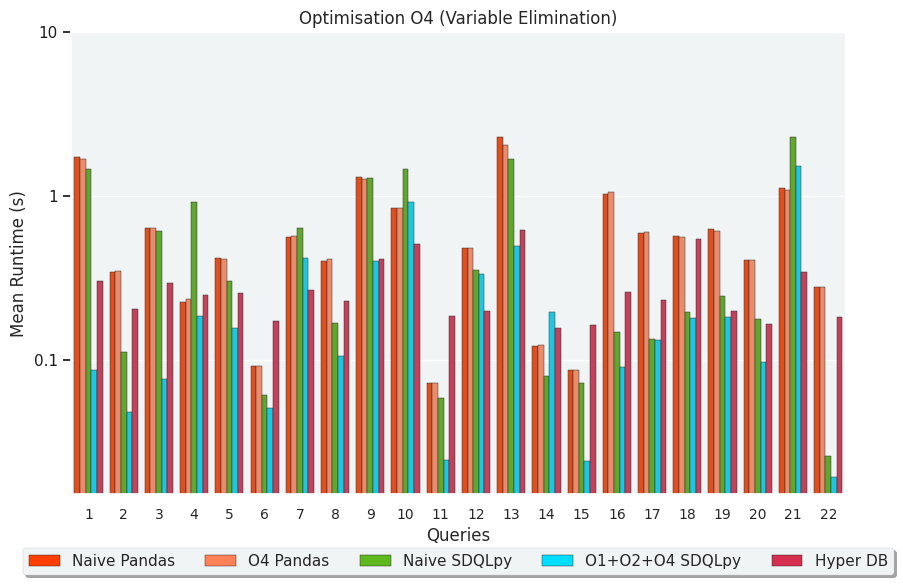

In [74]:
# All 4 Datapoints - TPC-H
class HesamColours(Enum):
    HYPER = "#D62E4E"
    NAIVE_SDQLPY = "#5EB91E"
    O1_O2_O4_SDQLPY = "#00DEFF"
    NAIVE_PANDAS = "#FF4000"
    O4_PANDAS = "#ff8157"

all_4_order = ["Naive Pandas", 'O4 Pandas', "Naive SDQLpy", 'O1+O2+O4 SDQLpy', "Hyper DB"]
all_4_data = results[results["Query Type"].isin(all_4_order)]

all_4_color = [HesamColours.NAIVE_PANDAS.value, HesamColours.O4_PANDAS.value,
               HesamColours.NAIVE_SDQLPY.value, HesamColours.O1_O2_O4_SDQLPY.value, HesamColours.HYPER.value]
all_4_hatch = [None, None, None, None, None]
all_4_filename = "../analysis_results/Hyper_SDQLpy_Optimisation_O4_01022024.jpg"
all_4_title = "Optimisation O4 (Variable Elimination)"

make_compare_graph(all_4_title,
                   all_4_data, 
                   all_4_order,
                   all_4_color,
                   all_4_hatch,
                   all_4_filename)

## Statistics

In [75]:
overall = results.groupby("Query Type").agg(
    overall_mean_runtime=("Mean", "mean")
)
overall = overall.sort_values(by="overall_mean_runtime")
overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})

overall.head(10)

,Overall Mean Runtime (s)
Query Type,
O1+O2+O4 SDQLpy,0.260713
Hyper DB,0.279434
O1+O2 SDQLpy,0.303240
O4 SDQLpy,0.439060
Naive SDQLpy,0.567511
O4 Pandas,0.633025
Naive Pandas,0.645916


In [76]:
# Should be: (OLD, NEW)
relevant_pairs = [
    ("Naive Pandas", "O4 Pandas"),
    ("Naive SDQLpy", "O4 SDQLpy"),
    ("O1+O2 SDQLpy", "O1+O2+O4 SDQLpy"),
    ("Hyper DB", "O1+O2+O4 SDQLpy")
]

def get_from_df_by_index(index_value):
    return float(overall.loc[[index_value]]["Overall Mean Runtime (s)"].iloc[0])

def percentage_reduction_in_time(old_time, new_time):
    return round(((old_time - new_time) / old_time) * 100, 2)

for old, new in relevant_pairs:
    old_value = get_from_df_by_index(old)
    new_value = get_from_df_by_index(new)
    print(f"Going from {old} to {new}, there was a {percentage_reduction_in_time(old_value, new_value)}% reduction in runtime")

Going from Naive Pandas to O4 Pandas, there was a 2.0% reduction in runtime
Going from Naive SDQLpy to O4 SDQLpy, there was a 22.63% reduction in runtime
Going from O1+O2 SDQLpy to O1+O2+O4 SDQLpy, there was a 14.02% reduction in runtime
Going from Hyper DB to O1+O2+O4 SDQLpy, there was a 6.7% reduction in runtime
